In [16]:
import casperfpga
from casperfpga.snapadc import SnapAdc
import logging
import time
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import numpy as np
import os
from argparse import ArgumentParser
%matplotlib widget
fs = 500
devname='snapadc'
# The device info could not match with your design,
# but it doesn't impact on reading the snapadc snapshot out.
devinfo={
    'adc_resolution': 8,
    'sample_rate': 500,
    'snap_inputs': 2
}
# We define which adc chip is used here.
# 0, 1, 2 means adc_chip a, b, c
adc_chip = 1

# read adc data from snapshot
#
def read_snapshot(snap):
    # trig the snapshot
    snap.registers['adc_trig'].write_int(0)
    snap.registers['adc_trig'].write_int(1)
    # read adc data from snapshot
    snap.snapshots['adc_snap'].arm()
    data = snap.snapshots['adc_snap'].read()['data']
    adc_data = data['data']
    # get 8bit data from 64bit data
    adc_raw = [[],[],[],[],[],[],[],[]]
    for i in range(len(adc_data)):
        for j in range(8):
            tmp = adc_data[i] & 0xff
            if(tmp < 128):
                adc_raw[j].append(tmp)
            else:
                adc_raw[j].append(tmp-256)
            adc_data[i] = adc_data[i]>>8
    # combine the 4 data streams into 2 streams
    # this is for 500MSps
    # TODO: we need to think about 1000MSps
    adc_a_i = []
    adc_a_q = []
    adc_b_i = []
    adc_b_q = []
    for i in range(len(adc_data)):
        adc_a_i.append(adc_raw[3][i])
        adc_a_i.append(adc_raw[2][i])
        adc_a_q.append(adc_raw[1][i])
        adc_a_q.append(adc_raw[0][i])
        adc_b_i.append(adc_raw[7][i])
        adc_b_i.append(adc_raw[6][i])
        adc_b_q.append(adc_raw[5][i])
        adc_b_q.append(adc_raw[4][i])
    return adc_a_i[0:512], adc_a_q[0:512]
'''
def read_snapshot(snap):
    adc=SnapAdc(snap, devname, devinfo)
    adc.snapshot()
    ss = adc.readRAM()
    adc_d = ss[adc_chip]
    adc_ch=adc_d.reshape(512,2)
    adc_ch=adc_ch.transpose()
    return adc_ch[0], adc_ch[1]
'''
# check the adc rms
#
def check_rms(di, dq):
    d=np.array(di)
    rms_i=np.sqrt(np.mean(d**2))
    d=np.array(dq)
    rms_q=np.sqrt(np.mean(d**2))
    print('%s : %.6f'%('RMS of ADC_I'.rjust(18), rms_i))
    print('%s : %.6f'%('RMS of ADC_Q'.rjust(18), rms_q))

# check the fpga clock
#
def check_clock(snap):
    clk_freq = snap.estimate_fpga_clock()
    print('%s : %.6f MHz'%('Fabric Clock Freq'.rjust(18), clk_freq))

# plot adc data in time domain and frequency domain
#
def plot_adc(di, dq):
    # define how many sample you want to plot
    n_plot = 64
    # Now, the script only supports 500MSps and 1000MSps
    Nfft = len(di)
    x=fs/Nfft*np.linspace(0,Nfft,Nfft)
    # plot adc_i_time and adc_i_fft
    fig = plt.figure()
    sub0 = fig.add_subplot(2,2,1)
    sub0.plot(di[1:n_plot])
    sub0.set_title('adc_i_time')
    
    sub1 = fig.add_subplot(2,2,3)
    #plt_a_fft = plt.subplot(2,2,3)
    a = np.array(di)
    fft_a = fft(a)
    sub1.plot(x,abs(fft_a))
    sub1.set_title('adc_i_fft')
    sub1.set_xlabel('MHz')
    #plt.tight_layout()
    #plt.show()
    # plot adc_q_time and adc_q_fft
    #plt_b_time = plt.subplot(2,2,2)
    sub2 = fig.add_subplot(2,2,2)
    sub2.plot(dq[1:n_plot])
    sub2.set_title('adc_q_time')
    #plt_b_fft = plt.subplot(2,2,4)
    sub3 = fig.add_subplot(2,2,4)
    b = np.array(dq)
    fft_b = fft(b)
    sub3.plot(x,abs(fft_b))
    sub3.set_title('adc_q_fft')
    sub3.set_xlabel('MHz')
    plt.tight_layout()
    plt.show()



**************************************
--SNAP Board IP:  192.168.2.100
**************************************


ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7f0660507940>>, <Future finished exception=KatcpClientError("Failed to connect to ('192.168.2.100', 69)")>)
Traceback (most recent call last):
  File "/home/wei/.conda/envs/py38/lib/python3.8/site-packages/tornado/ioloop.py", line 740, in _run_callback
    ret = callback()
  File "/home/wei/.conda/envs/py38/lib/python3.8/site-packages/tornado/ioloop.py", line 764, in _discard_future_result
    future.result()
  File "/home/wei/.conda/envs/py38/lib/python3.8/site-packages/tornado/gen.py", line 782, in run
    yielded = self.gen.send(value)
  File "/home/wei/.conda/envs/py38/lib/python3.8/site-packages/katcp/client.py", line 682, in _install
    raise KatcpClientError("Failed to connect to {0!r}"
katcp.core.KatcpClientError: Failed to connect to ('192.168.2.100', 69)


 Fabric Clock Freq : 250.343501 MHz
      RMS of ADC_I : 13.856970
      RMS of ADC_Q : 14.282652


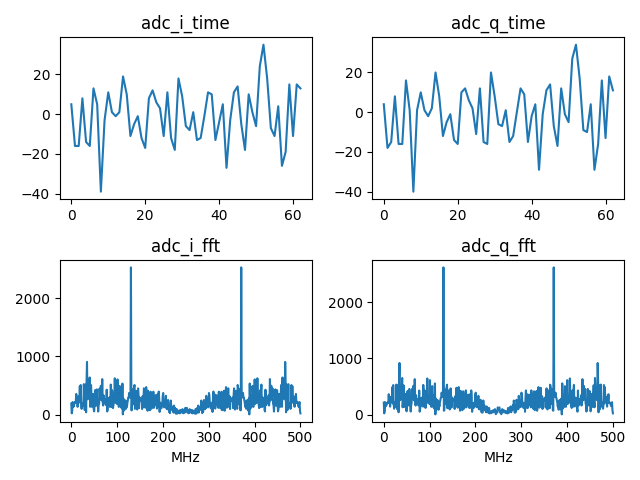

**************************************


In [4]:
def main():
    parser = ArgumentParser(description="Usage for SNAP status checking")
    parser.add_argument("--ip",type=str, dest="ip", default="192.168.2.100",help="ip address of SNAP board")
    parser.add_argument("--port",type=int, dest="port", default=69,help="communication port of SNAP board")
    parser.add_argument("--fpg",type=str, dest="fpg", default="limbo_500_2022-12-03_1749.fpg",help="fpg file you want to upload to the SNAP board")
    parser.add_argument("--all", dest="check_all", action="store_true", default=False,help="Check all the status.")
    parser.add_argument("--clock", dest="check_clock", action="store_true", default=False,help="Check Clock for SNAP board.")
    parser.add_argument("--rms", dest="check_rms", action="store_true", default=False,help="Check ADC RMS.")
    parser.add_argument("--plot", dest="plot", action="store_true", default=False,help="Plot the adc data in time domain and frequency domain.")
    opts = parser.parse_args(args=['--all', '--plot'])
    print('**************************************')
    print('--SNAP Board IP: ', opts.ip)
    print('**************************************')
    # connect to the SNAP board
    logger=logging.getLogger('snap')
    logging.basicConfig(filename='snap_adc.log',level=logging.DEBUG)
    snap = casperfpga.CasperFpga(opts.ip, opts.port, logger=logger)
    # check if snap board is connected
    if(snap.is_connected() == False):
        print('SNAP board is not connected.')
        print('Please check the SNAP board.')
        return

    fpg = '../fpg/'+opts.fpg
    snap.get_system_information(fpg,initialise_objects=False)
    # read adc data fron snapshot
    adc_a_i = []
    adc_a_q = []
    adc_a_i, adc_a_q = read_snapshot(snap)
            
    # check all the status, including clock and rms
    if(opts.check_all == True):
        check_clock(snap)
        check_rms(adc_a_i, adc_a_q)
    # check clock    
    if(opts.check_clock == True):
        check_clock(snap)
    # check rms
    if(opts.check_rms == True):
        check_rms(adc_a_i, adc_a_q)
    # plot adc data
    if(opts.plot == True):
        plot_adc(adc_a_i, adc_a_q)
    print('**************************************')
if __name__ == "__main__":
    main()

**************************************
--SNAP Board IP:  192.168.2.100
**************************************


ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7f0659d9e520>>, <Future finished exception=KatcpClientError("Failed to connect to ('192.168.2.100', 69)")>)
Traceback (most recent call last):
  File "/home/wei/.conda/envs/py38/lib/python3.8/site-packages/tornado/ioloop.py", line 740, in _run_callback
    ret = callback()
  File "/home/wei/.conda/envs/py38/lib/python3.8/site-packages/tornado/ioloop.py", line 764, in _discard_future_result
    future.result()
  File "/home/wei/.conda/envs/py38/lib/python3.8/site-packages/tornado/gen.py", line 782, in run
    yielded = self.gen.send(value)
  File "/home/wei/.conda/envs/py38/lib/python3.8/site-packages/katcp/client.py", line 682, in _install
    raise KatcpClientError("Failed to connect to {0!r}"
katcp.core.KatcpClientError: Failed to connect to ('192.168.2.100', 69)


 Fabric Clock Freq : 250.322901 MHz
      RMS of ADC_I : 13.958924
      RMS of ADC_Q : 14.380570


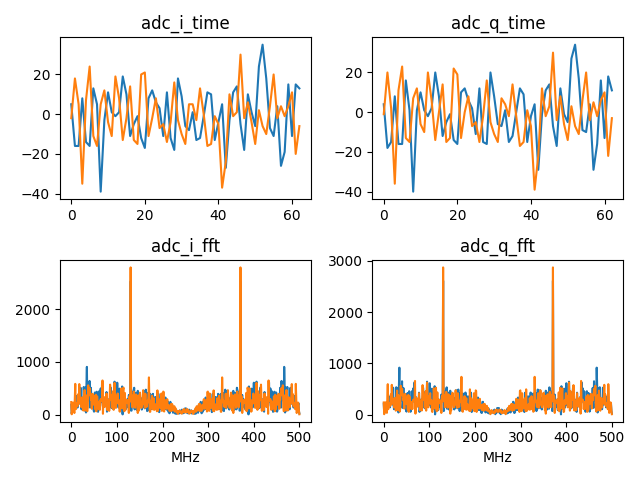

**************************************


In [7]:
parser = ArgumentParser(description="Usage for SNAP status checking")
parser.add_argument("--ip",type=str, dest="ip", default="192.168.2.100",help="ip address of SNAP board")
parser.add_argument("--port",type=int, dest="port", default=69,help="communication port of SNAP board")
parser.add_argument("--fpg",type=str, dest="fpg", default="limbo_500_2022-12-03_1749.fpg",help="fpg file you want to upload to the SNAP board")
parser.add_argument("--all", dest="check_all", action="store_true", default=False,help="Check all the status.")
parser.add_argument("--clock", dest="check_clock", action="store_true", default=False,help="Check Clock for SNAP board.")
parser.add_argument("--rms", dest="check_rms", action="store_true", default=False,help="Check ADC RMS.")
parser.add_argument("--plot", dest="plot", action="store_true", default=False,help="Plot the adc data in time domain and frequency domain.")
opts = parser.parse_args(args=['--all', '--plot'])
print('**************************************')
print('--SNAP Board IP: ', opts.ip)
print('**************************************')
# connect to the SNAP board
logger=logging.getLogger('snap')
logging.basicConfig(filename='snap_adc.log',level=logging.DEBUG)
snap = casperfpga.CasperFpga(opts.ip, opts.port, logger=logger)
# check if snap board is connected
if(snap.is_connected() == False):
    print('SNAP board is not connected.')
    print('Please check the SNAP board.')
    #return

fpg = '../fpg/'+opts.fpg
snap.get_system_information(fpg,initialise_objects=False)
# read adc data fron snapshot
adc_a_i = []
adc_a_q = []
adc_a_i, adc_a_q = read_snapshot(snap)

# check all the status, including clock and rms
if(opts.check_all == True):
    check_clock(snap)
    check_rms(adc_a_i, adc_a_q)
# check clock    
if(opts.check_clock == True):
    check_clock(snap)
# check rms
if(opts.check_rms == True):
    check_rms(adc_a_i, adc_a_q)
# plot adc data
if(opts.plot == True):
    plot_adc(adc_a_i, adc_a_q)
print('**************************************')

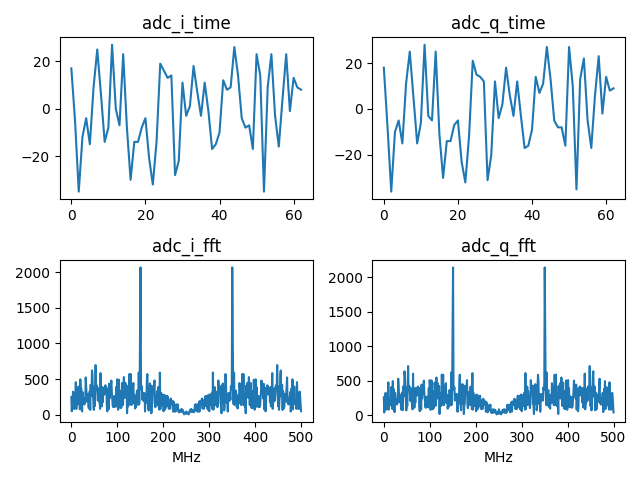

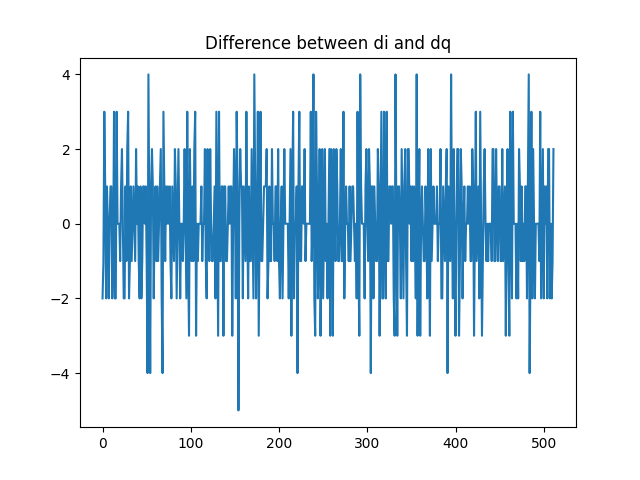

In [64]:
adc_a_i = []
adc_a_q = []
adc_a_i, adc_a_q = read_snapshot(snap)
plot_adc(adc_a_i, adc_a_q)
di = np.array(adc_a_i)
dq = np.array(adc_a_q)
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(di-dq)
sub.set_title('Difference between di and dq')
plt.show()
plt.close('all')